In [1]:
from fenics import *
import numpy as np
import time
from os import path

In [2]:
"""
Solve the 2D Darcy equation with homogeneous Dirichlet conditions varying diffusion coefficient:

  -grad(alpha(x,y) grad(u(x,y))) = f(x,y)    for all (x,y) \in (0,1)^2 (unit square)
                       u = 0                 on the boundary

  alpha(x,y) = piecewice constant function (constant within each subdomain) (diffusion coefficient)
  f = 1
  domain with subdomains:       -----.-----
                               |  2  |  3  |
                                -----.-----
                               |  1  |  4  |
                                -----.-----

"""

def solver(f, alphas, u_D, Nx, Ny, degree=1):
    """
    Solve the 2D Darcy equation -grad(k grad(u)) = f in the unit square 
    Args:   f (Expresssion) = source term
            alpha () = diffusion coefficient
            u_D (Expresssion) = boundary condition
            Nx, Ny (int) = number of cells in each direction --> the mesh will have 2*Nx*Ny number of Lagrange elements (triangles)
            degree = degree of the polynomial of the Lagrange space (default = 1)
    """
    assert len(alphas) == 4     #Sanity check

    # Create mesh and define function space
    mesh = UnitSquareMesh(Nx, Ny)

    # Define subdomain for then define alpha picewicely
    subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)     #first argument:String defining the type of the MeshFunction Allowed: ‘size_t’(--> )
    CompiledSubDomain("(x[0] < 0.5 + tol) && (x[1] < 0.5 + tol)", tol=1E-10).mark(subdomains, 1)    #left down 
    CompiledSubDomain("(x[0] < 0.5 + tol) && (x[1] > 0.5 - tol)", tol=1E-10).mark(subdomains, 2)    #left up 
    CompiledSubDomain("(x[0] > 0.5 - tol) && (x[1] > 0.5 - tol)", tol=1E-10).mark(subdomains, 3)    #right up 
    CompiledSubDomain("(x[0] > 0.5 - tol) && (x[1] < 0.5 + tol)", tol=1E-10).mark(subdomains, 4)    #right down

    dx = Measure("dx", domain=mesh, subdomain_data=subdomains)

    V = FunctionSpace(mesh, 'CG', degree)
    #print('Number of degree of freeedom = {}'.format(V.dim()))
    #print('Mesh size: h_min = {} and h_max = {}'.format(1/Nx, np.sqrt((1/Nx)**2 + (1/Ny)**2 )))

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_D, boundary)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = sum(dot(alpha*grad(u), grad(v))*dx(i) for i, alpha in enumerate(alphas, 1))
    L = f*v*dx

    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    #k_interp = interpolate(k, V)

    return u

def run_solver():
    "Run solver to compute solution"

    # Set up problem parameters and call solver
    u_D = Constant(0.0) 
    f = Constant(1.0)
    # Define vector of alphas
    alphas = [
        [Constant(10), Constant(10), Constant(10), Constant(10)],
        [Constant(0.5), Constant(0.8), Constant(0.5), Constant(0.8)],
        [Constant(10), Constant(50), Constant(80), Constant(2)]
    ]
    # Define mesh refinement: 2 \times Nx \times Ny = number of element in the mesh
    Nx = 100
    Ny = 100
    degree = 1
    u_file = File('FEM_solution/u.pvd')
    #k_file = File('solution/k.pvd')

    # Define grid where to project the solutions u and alphas for the NN
    sample_grid = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 5))      #list
    X, Y = sample_grid      #ndarray
    # Define grid where to project the solutions u and alphas for the plotting
    sample_grid = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))      #list
    Xp, Yp = sample_grid      #ndarray

    Z = []
    Z_plot = []
    for i, alpha in enumerate(alphas):
        u = solver(f, alpha, u_D, Nx, Ny, degree)
        sol = u
        sol.rename('u', 'u')
        u_file << (sol, float(i))

        Zi = np.array([sol(x, y) for x, y in zip(X.flatten(), Y.flatten())]).reshape(Y.shape)
        Z.append(Zi)
        Zi_plot = np.array([sol(x, y) for x, y in zip(Xp.flatten(), Yp.flatten())]).reshape(Yp.shape)
        Z_plot.append(Zi_plot)

    Z = np.stack(Z, axis=0)     #axis=number of different alphas we are considering
    Z_plot = np.stack(Z_plot, axis=0)
    # axis = 0 --> Z.shape = (3,5,10). This should be the right one!
    # axis = 1 --> Z.shape = (5,3,10)
    # axis = 2 --> Z.shape = (5,10,3)
    return Xp, Yp, Z_plot, alphas

if __name__ == '__main__':

    start_time = time.time()                
    Xp, Yp, Z_plot, alphas = run_solver()
    elapsed = time.time() - start_time                
    print('Implementation time: %.4f' % (elapsed))
    


Implementation time: 0.5871


plot solution for alpha = [10. 10. 10. 10.]


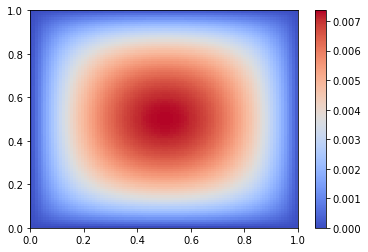

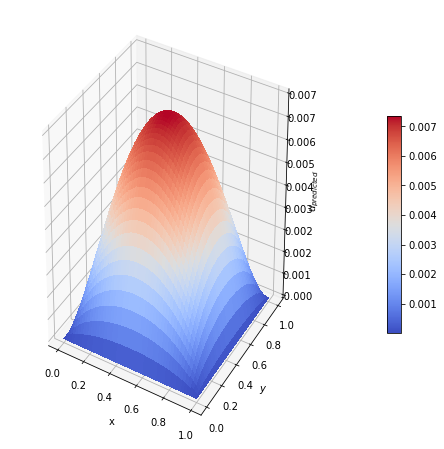

u_pred minimum = -1.4141682663347328e-20


In [3]:
# Importing library for plotting
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt


alphas = arr = np.array(alphas, dtype='float32')   
print('plot solution for alpha = {}'.format(alphas[0,:])) 

# Plotting the surface
# 2D plot
fig, ax = plt.subplots()
p = ax.pcolor(Xp, Yp, Z_plot[0,:,:], cmap= cm.coolwarm) #, vmin=U_pred.min(), vmax=U_pred.max())
cb = fig.colorbar(p, ax=ax)

# 3D plot
fig = plt.figure(figsize=(8,8))
plt.rcParams["text.usetex"] = False
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Xp, Yp, Z_plot[0,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))

ax.set_xlabel('x')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$u_{predicted}$')
   
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=15, pad=0.15) 

plt.show()

print('u_pred minimum = {}'.format(Z_plot[0,:,:].min()))

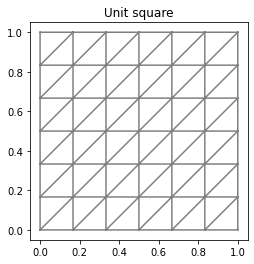

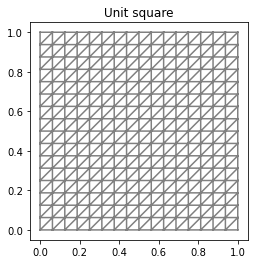

In [4]:
from dolfin import *
import matplotlib.pyplot as plt

Nx = 6
Ny = 6
mesh = UnitSquareMesh(Nx, Ny)
plt.figure()
plot(mesh, title="Unit square")

Nx = 16
Ny = 16
mesh = UnitSquareMesh(Nx, Ny)
plt.figure()
plot(mesh, title="Unit square")